# Build an Augmented LLM with Tools in LangGraph

## Learning Objectives
By the end of this notebook, you will be able to:
1. **Understand tool augmentation** - Learn why and how to give LLMs access to tools
2. **Create custom tools** - Define tools using the `@tool` decorator
3. **Bind tools to LLMs** - Attach tools to language models
4. **Use LangGraph's ToolNode** - Leverage built-in tool execution

## Why Augment LLMs with Tools?

LLMs have inherent limitations:
- **Knowledge cutoff** - Training data has a date limit
- **No real-time access** - Can't fetch current information
- **Limited computation** - Struggle with complex math
- **No external actions** - Can't send emails, query databases, etc.

**Tools** extend LLM capabilities by allowing them to:
- Search the web for current information
- Execute calculations accurately
- Query databases and APIs
- Perform actions in the real world

## What We're Building

```
┌─────────────────────────────────────────────────────────────────┐
│               AUGMENTED LLM ARCHITECTURE                        │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  User Query ──► [LLM + Tools] ──►  Decision:                    │
│                                     ├─► Answer directly         │
│                                     └─► Call a tool             │
│                                                                  │
│  Tools Available:                                                │
│    • search_web: Search the internet for information            │
│    • (more tools can be added)                                  │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘
```

We already know Tools help the LLM interact with external sources of information like web search.

Augmented LLM with Search Tool: Here we will build a simple augmented LLM using the capabilities of Tavily Search as a tool to allow the LLM to fetch relevant information from the web when necessary.

![](https://i.imgur.com/5r015dw.png)

In [1]:
# ============================================================================
# SETUP: Import dependencies and LLM helper functions
# ============================================================================
import os
import sys

# Add parent directory to path for importing helpers
sys.path.append(os.path.abspath(".."))

# Import LLM factory functions
from helpers.utils import get_groq_llm, get_openai_llm

print("Setup complete! Ready to build an augmented LLM.")

## Step 1: Define the State

For tool-augmented LLMs, the state needs to track messages which may include:
- **HumanMessage** - User's input query
- **AIMessage** - LLM's response (may contain tool calls)
- **ToolMessage** - Results returned from tool execution

The `add_messages` reducer ensures all these are preserved in order.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [2]:
# ============================================================================
# DEFINING STATE FOR TOOL-AUGMENTED LLM
# ============================================================================
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State schema for tool-augmented LLM.
    
    The messages list will contain a mix of:
    - HumanMessage: User queries
    - AIMessage: LLM responses (possibly with tool_calls)
    - ToolMessage: Results from tool execution
    
    Using add_messages reducer to preserve the full interaction history.
    """
    messages: Annotated[list, add_messages]

## Step 2: Create and Bind Tools to the LLM

### What is a Tool?
A **tool** is a function that the LLM can decide to call. It consists of:
1. **Function definition** - The actual Python code to execute
2. **Name** - How the LLM refers to the tool
3. **Description** - Helps the LLM decide when to use the tool
4. **Parameters** - What inputs the tool expects

### The @tool Decorator
LangChain's `@tool` decorator transforms a Python function into a tool:
- Automatically extracts the function name
- Uses the docstring as the description
- Infers parameter types from type hints

### Binding Tools to LLMs
`llm.bind_tools(tools)` creates an augmented LLM that:
- Knows about available tools and their capabilities
- Can decide whether to call a tool or respond directly
- Generates structured tool call requests when needed

Here we define our custom search tool and then bind it to the LLM to augment the LLM.

In [3]:
# ============================================================================
# CREATING AND BINDING TOOLS TO THE LLM
# ============================================================================
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool

# -----------------------------------------------------------------------------
# Step 1: Initialize the base LLM
# We use Groq for fast inference (can swap to OpenAI)
# -----------------------------------------------------------------------------
llm = get_groq_llm()
print(f"Base LLM initialized")

# -----------------------------------------------------------------------------
# Step 2: Create a search tool using Tavily
# Tavily is a search API designed for AI applications
# -----------------------------------------------------------------------------
tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str, num_results: int = 5):
    """
    Search the web for a query. Useful for general information or general news.
    
    This docstring is CRITICAL - it tells the LLM:
    - WHAT the tool does (search the web)
    - WHEN to use it (for general info/news)
    
    Args:
        query: The search query to look up
        num_results: Number of results to return (default 5)
        
    Returns:
        Search results from the web
    """
    print(f"  [Tool] Searching web for: '{query}'")
    results = tavily_search.raw_results(
        query=query,
        max_results=num_results,
        search_depth='advanced',
        include_raw_content=True
    )
    return results

# -----------------------------------------------------------------------------
# Step 3: Create the tools list and bind to LLM
# bind_tools() creates an "augmented" LLM that knows about these tools
# -----------------------------------------------------------------------------
tools = [search_web]  # List of all available tools

# Bind tools to the LLM
# This creates a new LLM that can decide to call tools when needed
llm_with_tools = llm.bind_tools(tools=tools)

print(f"LLM augmented with {len(tools)} tool(s): {[t.name for t in tools]}")

In [4]:
# ============================================================================
# TEST: Call the tool directly
# ============================================================================
# We can invoke the tool directly to test it works
# This is useful for debugging before integrating with the LLM

print("Testing search_web tool directly:")
print("-" * 50)

result = search_web.invoke('what is AI in 1 line')

# Show a summary of results
print(f"\nReturned {len(result.get('results', []))} results")
if result.get('results'):
    print(f"First result title: {result['results'][0].get('title', 'N/A')}")

{'query': 'what is AI in 1 line',
 'response_time': 1.33,
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/what-is/artificial-intelligence/',
   'title': 'What is Artificial Intelligence (AI)? - AWS',
   'content': '## What Is Artificial Intelligence (AI)?\n\nArtificial Intelligence (AI) is a transformative technology that enables machines to perform human-like problem-solving tasks. From recognizing images and generating creative content to making data-driven predictions, AI empowers businesses to make smarter decisions at scale.\n\nIn today’s digital landscape, organizations generate vast amounts of data from sensors, user interactions, and system logs. AI harnesses this data to streamline operations—automating customer support, enhancing marketing strategies, and providing actionable insights through advanced analytics. [...] Artificial intelligence (AI) is an umbrella term for different strategies and techniques for making m

In [5]:
# ============================================================================
# TEST: LLM decides NOT to use tool (direct answer)
# ============================================================================
# For simple questions, the LLM may choose to answer directly
# without calling any tools

print("Query: 'what is AI in 1 line'")
print("-" * 50)
print("This is a simple question - LLM likely answers directly\n")

response = llm_with_tools.invoke('what is AI in 1 line')

# Check if the LLM called any tools
if response.tool_calls:
    print(f"LLM decided to call tools: {[tc['name'] for tc in response.tool_calls]}")
else:
    print("LLM answered directly (no tool calls)")
    print(f"\nResponse: {response.content}")

AIMessage(content='Artificial intelligence is the field of computer science that creates systems capable of performing tasks that normally require human intelligence, such as learning, reasoning, and perception.', additional_kwargs={'reasoning_content': 'User asks: "what is AI in 1 line". Provide a concise definition. No need for external info. Just answer.'}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 147, 'total_tokens': 213, 'completion_time': 0.139389486, 'completion_tokens_details': {'reasoning_tokens': 27}, 'prompt_time': 0.005622963, 'prompt_tokens_details': None, 'queue_time': 0.055371838, 'total_time': 0.145012449}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdbb0-3a5b-73c2-9fbc-d0dafabdc757-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 147, 'output_tokens': 66, 'total_to

In [6]:
# ============================================================================
# TEST: LLM decides TO USE tool (needs current info)
# ============================================================================
# For questions requiring current/real-time information,
# the LLM should decide to call the search tool

print("Query: 'what is the latest news on nvidia'")
print("-" * 50)
print("This requires current info - LLM should use the search tool\n")

response = llm_with_tools.invoke('what is the latest news on nvidia')

# Check if the LLM called any tools
if response.tool_calls:
    print("LLM decided to call a tool!")
    print(f"Tool calls: {response.tool_calls}")
    print("\nNote: The response contains tool_calls instead of content")
    print("The actual tool execution happens in a ToolNode (next section)")
else:
    print("LLM answered directly (no tool calls)")
    print(f"Response: {response.content}")

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "what is the latest news on nvidia". Need up-to-date info. Use web search.', 'tool_calls': [{'id': 'fc_59deb81f-12bd-471c-94af-c8d2c16aaf0e', 'function': {'arguments': '{"num_results":10,"query":"latest news Nvidia January 2026"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 148, 'total_tokens': 214, 'completion_time': 0.142249837, 'completion_tokens_details': {'reasoning_tokens': 25}, 'prompt_time': 0.00576271, 'prompt_tokens_details': None, 'queue_time': 0.054217539, 'total_time': 0.148012547}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_8a618bed98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bdbb0-3c18-7f13-aa37-3ff54cfe3ef7-0', tool_calls=[{'name': 'search_web', 'args': {'num_results': 10, 'query': 'latest news Nvidia January 2026'},

---

## Step 3: Create the Graph with the Augmented LLM

### Key LangGraph Components for Tool Use

| Component | Purpose |
|-----------|---------|
| **ToolNode** | Pre-built node that executes tool calls |
| **tools_condition** | Pre-built routing function for tool decisions |

### How it Works

1. **LLM Node** receives user message and returns:
   - Direct response (no tools needed), OR
   - Tool call request (tools needed)

2. **tools_condition** checks the LLM response:
   - If `tool_calls` present → route to ToolNode
   - If no `tool_calls` → route to END

3. **ToolNode** executes the requested tools and returns results

```
                    ┌─────────────────┐
                    │ tool_calling_llm│
                    └────────┬────────┘
                             │
                    ┌────────▼────────┐
                    │ tools_condition │
                    └────────┬────────┘
               ┌─────────────┴─────────────┐
               │                           │
               ▼                           ▼
         ┌──────────┐                 ┌─────────┐
         │  tools   │                 │   END   │
         │(ToolNode)│                 │         │
         └──────────┘                 └─────────┘
```

![](https://i.imgur.com/5r015dw.png)

In [7]:
# ============================================================================
# BUILD THE AUGMENTED LLM GRAPH
# ============================================================================
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# -----------------------------------------------------------------------------
# Step 1: Define the LLM node with tool-calling capability
# This node calls our tool-augmented LLM
# -----------------------------------------------------------------------------
def tool_calling_llm(state: State) -> State:
    """
    Node that calls the tool-augmented LLM.
    
    The LLM will:
    1. Analyze the user's message
    2. Decide if tools are needed
    3. Return either:
       - A direct response (AIMessage with content)
       - A tool call request (AIMessage with tool_calls)
    """
    current_messages = state["messages"]
    response = llm_with_tools.invoke(current_messages)
    return {"messages": [response]}

# -----------------------------------------------------------------------------
# Step 2: Build the graph
# -----------------------------------------------------------------------------
builder = StateGraph(State)

# Add the LLM node (makes decisions about tool use)
builder.add_node("tool_calling_llm", tool_calling_llm)

# Add the ToolNode (executes tools when called)
# ToolNode is a pre-built node that:
# - Extracts tool calls from the AIMessage
# - Executes each tool with provided arguments
# - Returns ToolMessage(s) with results
builder.add_node("tools", ToolNode(tools=tools))

# Entry point
builder.add_edge(START, "tool_calling_llm")

# -----------------------------------------------------------------------------
# Step 3: Add conditional routing based on tool_calls
# tools_condition is a pre-built function that:
# - Returns "tools" if the LLM response has tool_calls
# - Returns END if no tool_calls (direct response)
# -----------------------------------------------------------------------------
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # Built-in routing: checks for tool_calls in response
    # Automatically routes to "tools" or END
)

# After tools execute, we're done (for this simple example)
builder.add_edge("tools", END)

# Compile
graph = builder.compile()

print("Augmented LLM graph compiled!")
print("Graph structure:")
display(Image(graph.get_graph().draw_mermaid_png()))

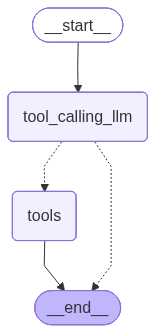

In [8]:
# ============================================================================
# VISUALIZE THE GRAPH
# ============================================================================
# Notice the conditional edge from tool_calling_llm
# It can go to either "tools" or "__end__"

print("Graph Visualization:")
print("-" * 50)
print("Flow options:")
print("  1. START → tool_calling_llm → END (no tools needed)")
print("  2. START → tool_calling_llm → tools → END (tools called)")
print("-" * 50)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# ============================================================================
# TEST 1: Query that DOESN'T need tools
# ============================================================================
# Simple factual question - LLM can answer from training data
# Expected: Direct response, no tool calls

print("=" * 70)
print("TEST 1: Simple query (no tools needed)")
print("Query: 'Explain AI in 2 bullets'")
print("=" * 70)

user_input = "Explain AI in 2 bullets"

print("\nStreaming graph execution:\n")
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

print("\n" + "=" * 70)
print("Observation: LLM answered directly without calling any tools")
print("=" * 70)

================================ Human Message =================================

Explain AI in 2 bullets
================================== Ai Message ==================================

- **Artificial Intelligence (AI)** is the field of computer science that creates systems capable of performing tasks that normally require human intelligence—such as learning, reasoning, perception, and decision‑making—by using algorithms, data, and computational models (e.g., machine learning, neural networks, symbolic reasoning).  

- **AI works by extracting patterns from data (training) and applying those learned patterns to new situations (inference), enabling applications like image/video recognition, natural‑language understanding, recommendation engines, autonomous robots, and many other technologies that automate or augment human capabilities.**


In [10]:
# ============================================================================
# TEST 2: Query that NEEDS tools (current information)
# ============================================================================
# This question requires current/real-time information
# Expected: LLM calls search_web tool, results returned

print("=" * 70)
print("TEST 2: Query requiring current information (tools needed)")
print("Query: 'What is the latest news on OpenAI product releases'")
print("=" * 70)

user_input = "What is the latest news on OpenAI product releases"

print("\nStreaming graph execution:\n")
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

print("\n" + "=" * 70)
print("Observation: LLM decided to use the search_web tool!")
print("The flow was: LLM → tool call → ToolNode executes → Results returned")
print("=" * 70)

================================ Human Message =================================

What is the latest news on OpenAI product releases
================================== Ai Message ==================================
Tool Calls:
  search_web (fc_7cc898d1-f73a-4fe4-a6ea-f136d834051f)
 Call ID: fc_7cc898d1-f73a-4fe4-a6ea-f136d834051f
  Args:
    num_results: 10
    query: latest news OpenAI product releases 2025 2026
================================= Tool Message =================================
Name: search_web

{"query": "latest news OpenAI product releases 2025 2026", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://openai.com/news/", "title": "OpenAI News", "content": "Image 2: OAI Go Blog ArtCard 1x1\n\nIntroducing ChatGPT Go, now available worldwide Product Jan 16, 2026\n\nImage 3: OAI Ads Blog ArtCard 1x1\n\nOur approach to advertising and expanding access to ChatGPT Company Jan 16, 2026\n\nImage 4: OpenAI for Healthcare > Cover Image\n\nIntrod

---

## Summary: Key Takeaways

### What We Built
An augmented LLM that can:
- Decide when to use external tools
- Execute web searches for current information
- Return results to the user

### Key Concepts

| Concept | Description |
|---------|-------------|
| **@tool decorator** | Converts Python functions to LLM-callable tools |
| **bind_tools()** | Attaches tools to an LLM |
| **ToolNode** | Pre-built node that executes tool calls |
| **tools_condition** | Pre-built routing based on tool_calls |

### The Tool-Use Pattern

```
1. LLM receives query
2. LLM decides: Can I answer directly, or do I need tools?
3a. Direct answer → Return response → END
3b. Need tools → Generate tool_call → ToolNode executes → Return results
```

### Important Limitation
**This version has no feedback loop!** The tool results go to END, not back to the LLM.
This means:
- The LLM can't process tool results
- No human-readable response from tool outputs
- Can't chain multiple tool calls

**Solution**: In the next notebook, we'll add a **feedback loop** to create a true AI Agent!

### Next Steps
Build a complete **Tool-Use AI Agent** with feedback loops that:
- Processes tool results with the LLM
- Generates human-readable responses
- Can call multiple tools in sequence